<a href="https://colab.research.google.com/github/shreyab375/LSTM-Forecasting-Models-/blob/main/CNN%2BLSTM%2BAttention_Models_for_Time_Series_Backcasting__using_multiple_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:

#Step 1
import numpy as np
import joblib
import pandas as pd
import datetime
import tensorflow as tf
import os
import random
import timeit
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential, Model
from keras.layers import Input, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, Activation, Flatten, concatenate, Permute, Multiply
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import RootMeanSquaredError

In [62]:
#Reade the data
df_sn=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/snv1_full.csv', sep=",", header=0)
#convert the date to datetime format
df_sn.Date = pd.to_datetime(df_sn.Date)

In [63]:
#Select the values from 1900 to avoid any data gaps
df_sn = df_sn.set_index('Date')
df_sn = df_sn.truncate(before = '1850-01-01', after ='2024-01-01')
df_sn = df_sn.reset_index()

In [64]:
df_sn = df_sn.sort_values("Date",ascending = False)

In [65]:
df_sn.shape

(60416, 2)

In [66]:
df_sn = df_sn.dropna()

In [67]:
df_sn.shape

(60416, 2)

In [68]:
# Create lag features (e.g., lag 1 day, lag 7 days, lag 365 days)
#df_sn['Sn_lag1'] = df_sn['Sn'].shift(1).fillna(method='bfill', inplace=True)
#df_sn['Sn_lag7'] = df_sn['Sn'].shift(7).fillna(method='bfill', inplace=True)
#df_sn['Sn_lag365'] = df_sn['Sn'].shift(365).fillna(method='bfill', inplace=True)

# Create moving averages or weighted averages (same values across the rolling window)
df_sn['Sn_rolling_30'] = df_sn['Sn'].rolling(window=30, min_periods=1).mean().transform(lambda x: x.ffill())
df_sn['Sn_rolling_365'] = df_sn['Sn'].rolling(window=365, min_periods=1).mean().transform(lambda x: x.ffill())
df_sn['Sn_rolling_2000'] = df_sn['Sn'].rolling(window=2000, min_periods=1).mean().transform(lambda x: x.ffill())

# Create rolling standard deviations
#df_sn['Sn_rolling_std_30'] = df_sn['Sn'].rolling(window=30).std()

# Now use these features for modeling with LSTM or any other model

In [69]:
df_sn

,Date,Sn,Sn_rolling_30,Sn_rolling_365,Sn_rolling_2000
60415,2015-05-31,17,17.000000,17.000000,17.000000
60414,2015-05-30,19,18.000000,18.000000,18.000000
60413,2015-05-29,22,19.333333,19.333333,19.333333
60412,2015-05-28,8,16.500000,16.500000,16.500000
60411,2015-05-27,9,15.000000,15.000000,15.000000
...,...,...,...,...,...
4,1850-01-05,57,78.300000,66.019178,45.328500
3,1850-01-04,52,76.266667,65.983562,45.354500
2,1850-01-03,114,76.933333,66.134247,45.411500
1,1850-01-02,85,76.133333,66.243836,45.454000


In [70]:
df_sn.columns


Index(['Date', 'Sn', 'Sn_rolling_30', 'Sn_rolling_365', 'Sn_rolling_2000'], dtype='object')

In [71]:
#Step 3
# Split the data into training, validation, and test sets
n = len(df_sn)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
n_test = n - n_train - n_val

train_data = df_sn[:n_train].drop(columns='Date').values
train_date = df_sn[:n_train].drop(columns=['Sn',  'Sn_rolling_30',
       'Sn_rolling_365', 'Sn_rolling_2000'])

val_data   = df_sn[n_train:n_train+n_val].drop(columns='Date').values
val_date   = df_sn[n_train:n_train+n_val].drop(columns=['Sn',  'Sn_rolling_30',
       'Sn_rolling_365', 'Sn_rolling_2000'])

test_data  = df_sn[-n_test:].drop(columns=['Date']).values
test_date  = df_sn[-n_test:].drop(columns=['Sn'])


In [37]:
#Select days that are spread around
#train_data = train_data[::5]  # Select every 5th element
#train_date = train_date[::5]  # Select every 5th element

In [38]:
#plt.plot(df_sn.Date, df_sn.Sn)
#plt.plot(train_date, train_data,  color = "red")

In [39]:
#print(train_date, train_data)

In [72]:
print('Train Set      : ',len(train_data))
print('Validation Set : ',len(val_data))
print('Test Set       : ',len(test_data))

Train Set      :  48332
Validation Set :  6041
Test Set       :  6043


In [73]:
#Step 4
# Normalize the data using StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
val_data   = scaler.transform(val_data)
test_data  = scaler.transform(test_data)

In [74]:
#Step 5
# Prediction intervals
ten_days = 10
hundred_days = 100
one_year = 365
ten_years = 3650

# Prepare the datasets
ten_day_date = test_date.head(ten_days)
ten_day_data = test_data[:ten_days]

hundred_day_date = test_date.head(hundred_days)
hundred_day_data = test_data[:hundred_days]

one_year_date = test_date.head(one_year)
one_year_data = test_data[:one_year]

ten_year_date = test_date.head(ten_years)
ten_year_data = test_data[:ten_years]

In [75]:
#Step 6
#Create a windowed dataset for training
# Assume test_data is your feature (e.g., SN) and is a numpy array
def reshape_data(data, time_steps):
    X = []
    y = []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    X = np.array(X)
    y = np.array(y)
    return X, y

In [76]:
original_data = scaler.inverse_transform(train_data)
original_data

array([[17.        , 17.        , 17.        , 17.        ],
       [19.        , 18.        , 18.        , 18.        ],
       [22.        , 19.33333333, 19.33333333, 19.33333333],
       ...,
       [45.        , 42.1       , 66.4630137 , 39.4855    ],
       [67.        , 44.2       , 66.4109589 , 39.519     ],
       [40.        , 45.        , 66.28767123, 39.539     ]])

In [77]:
#Step 7
#Let's create a time step of 10 days
## Example: Predict for 10 days (using 10 days history to predict the next day)
time_steps = 27
X_train, y_train = reshape_data(train_data, time_steps)
X_val, y_val     = reshape_data(val_data, time_steps)
X_test, y_test   = reshape_data(test_data, time_steps)

In [78]:
#Step 8
def cc(y_true, y_pred):
    """
    Compute the correlation coefficient between y_true and y_pred.
    """
    # Compute the covariance matrix
    cov = tfp.stats.covariance(y_true, y_pred, sample_axis=0)

    # Compute the standard deviation of y_true and y_pred
    std_true = K.std(y_true)
    std_pred = K.std(y_pred)

    # Compute the correlation coefficient
    return cov / (std_true * std_pred)


In [79]:

#Step 8
from tensorflow.keras.layers import Layer

class Attention(Layer):
    def __init__(self, return_sequences=True, **kwargs):
        super(Attention, self).__init__()
        self.return_sequences = return_sequences

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, inputs):
        logits = tf.matmul(inputs, self.W)
        attention_weights = tf.nn.softmax(logits, axis=1)
        weighted_inputs = inputs * attention_weights
        if self.return_sequences:
            return weighted_inputs
        else:
            return tf.reduce_sum(weighted_inputs, axis=1)

In [84]:
# Example: Input shape = (time steps, features)
input_shape = (27, 4)  # Modify for different horizons (e.g., 10 days, 100 days, etc.)
model = Sequential([
    # Conv1D layer with 8 filters and kernel size of 1, expects (time_steps, features)
    Conv1D(filters=4, kernel_size=1, activation='relu', input_shape=(27, 4)),
    Conv1D(filters=4, kernel_size=1, activation='relu'),
    MaxPooling1D(pool_size=2),  # This reduces the sequence length by a factor of 2

    # Ensure the output from MaxPooling1D matches the input requirements of the LSTM
    Bidirectional(LSTM(64, return_sequences=True)),  # Return sequences for Attention layer

    # Attention layer expects 3D input (batch_size, time_steps, features)
    # Here we assume the Attention layer is compatible with the output of Bidirectional LSTM
    # If it’s incompatible, you might need to adjust the dimensions or layer configurations
    Attention(),

    Dropout(0.2),

    # Final Bidirectional LSTM layer processes the sequences
    Bidirectional(LSTM(64)),

    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])


In [85]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)                   │ (None, 27, 4)               │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 27, 4)               │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 13, 4)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ (None, 13, 128)             │          35,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_5 (Attention)              │ (None, 13, 128)             │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 13, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 138,473 (540.91 KB)

 Trainable params: 138,473 (540.91 KB)

 Non-trainable params: 0 (0.00 B)

In [86]:
#Compile Model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer= optimizer,
              loss=tf.keras.losses.Huber(),
              metrics= [RootMeanSquaredError()])

In [87]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5, verbose=1,
                               mode='min',
                               restore_best_weights=True)

In [88]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping])

Epoch 1/100
3020/3020 ━━━━━━━━━━━━━━━━━━━━ 89s 28ms/step - loss: 0.3546 - root_mean_squared_error: 0.9240 - val_loss: 0.1365 - val_root_mean_squared_error: 0.5331
Epoch 2/100
3020/3020 ━━━━━━━━━━━━━━━━━━━━ 82s 27ms/step - loss: 0.1559 - root_mean_squared_error: 0.5854 - val_loss: 0.1312 - val_root_mean_squared_error: 0.5220
Epoch 3/100
3020/3020 ━━━━━━━━━━━━━━━━━━━━ 140s 27ms/step - loss: 0.1560 - root_mean_squared_error: 0.5847 - val_loss: 0.1299 - val_root_mean_squared_error: 0.5192
Epoch 4/100
3020/3020 ━━━━━━━━━━━━━━━━━━━━ 83s 27ms/step - loss: 0.1564 - root_mean_squared_error: 0.5856 - val_loss: 0.1295 - val_root_mean_squared_error: 0.5184
Epoch 5/100
3020/3020 ━━━━━━━━━━━━━━━━━━━━ 87s 29ms/step - loss: 0.1538 - root_mean_squared_error: 0.5801 - val_loss: 0.1391 - val_root_mean_squared_error: 0.5358
Epoch 6/100
3020/3020 ━━━━━━━━━━━━━━━━━━━━ 80s 26ms/step - loss: 0.1552 - root_mean_squared_error: 0.5833 - val_loss: 0.1293 - val_root_mean_squared_error: 0.5187
Epoch 7/100
3020/3020

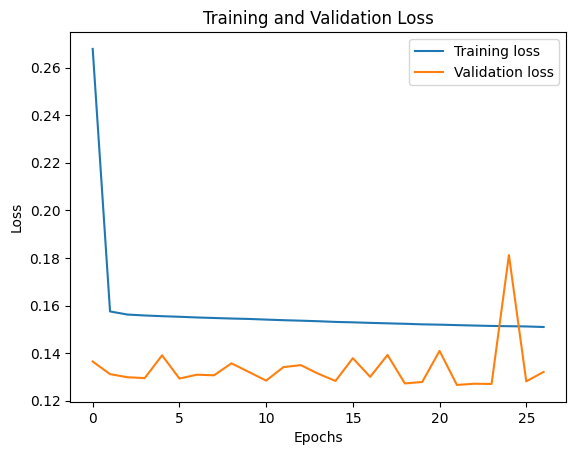

In [89]:
# Plot the training and validation metrics
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

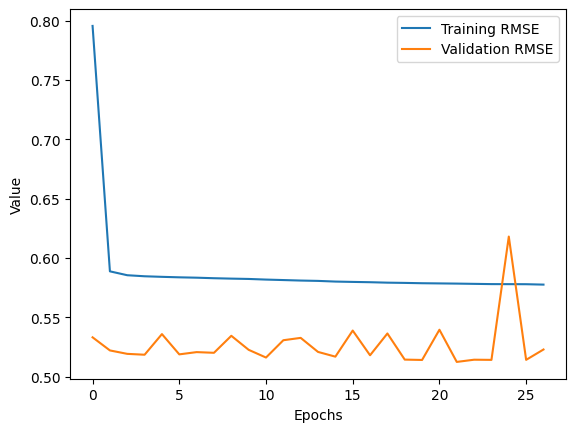

In [90]:
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

In [91]:
# Evaluate the model on the test set
test_loss, test_rmse = model.evaluate(X_test, y_test)

# Make predictions on the test set
y_pred = model.predict(X_test)

188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0829 - root_mean_squared_error: 0.4079
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


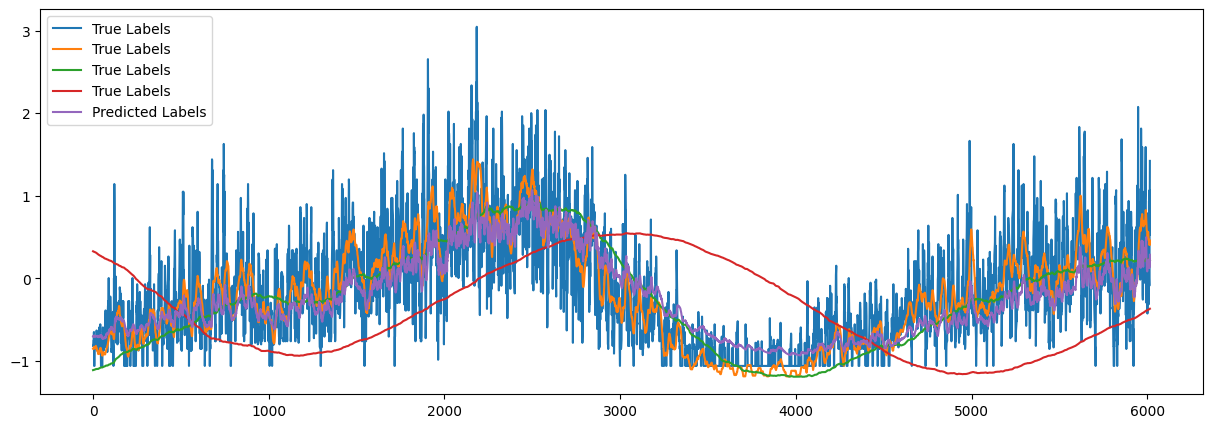

In [92]:
# Plot the predicted and true labels
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(y_test, label='True Labels')
plt.plot(y_pred, label='Predicted Labels')
plt.legend()
plt.show()

In [93]:
#Step 9
#Evaluate the model on the 10, 100, 356 Days to Forecast
X_ten   = X_test[:10]
X_hundred = X_test[:100]
X_year = X_test[:365]

y_ten   = y_test[:10]
y_hundred = y_test[:100]
y_year = y_test[:365]

print("10 Day to Backcast")
test_loss, test_rmse = model.evaluate(X_ten, y_ten)
y_pred_ten = model.predict(X_ten)


print("100 Days to Backcast")
test_loss, test_rmse = model.evaluate(X_hundred, y_hundred)
y_pred_hundred = model.predict(X_hundred)

print("365 Days to Backcast")
test_loss, test_rmse = model.evaluate(X_year, y_year)
y_pred_year = model.predict(X_year)

10 Day to Backcast
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1600 - root_mean_squared_error: 0.5659
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
100 Days to Backcast
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1462 - root_mean_squared_error: 0.5407 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
365 Days to Backcast
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1195 - root_mean_squared_error: 0.4878
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [96]:
#Step 10
#Inverse from scaled data
#inv_pred_ten = scaler.inverse_transform(y_pred_ten)
#inv_ten      = scaler.inverse_transform(y_ten)

#inv_pred_hundred = scaler.inverse_transform(y_pred_hundred)
#inv_hundred      = scaler.inverse_transform(y_hundred)

#inv_pred_year = scaler.inverse_transform(y_pred_year)
#inv_year     = scaler.inverse_transform(y_year)

#Copy data date
viz_ten   = ten_day_date.copy()
viz_hundred = hundred_day_date.copy()
viz_year = one_year_date.copy()

#Join true and predicted data
viz_ten['sn_pred'] = y_pred_ten[:, 0]
viz_ten['sn_true'] = y_ten[:, 0]

viz_hundred['sn_pred'] = y_pred_hundred[:, 0]
viz_hundred['sn_true'] = y_hundred[:, 0]

viz_year['sn_pred'] = y_pred_year[:, 0]
viz_year['sn_true'] = y_year[:, 0]

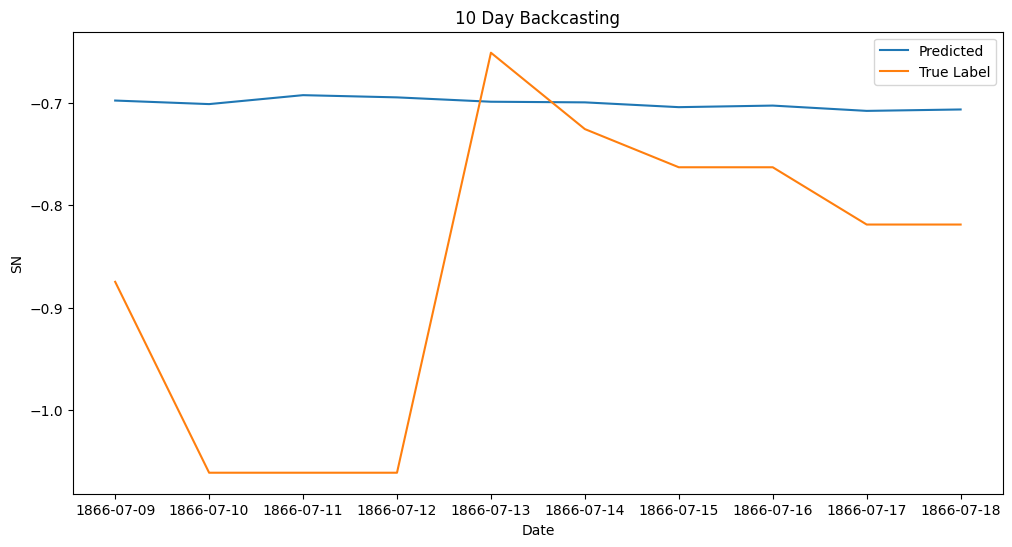

In [97]:
#10 Day Backcast

# Load dataset
viz_ten = viz_ten.set_index('Date')

# Plot two columns in one chart
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(viz_ten.index, viz_ten['sn_pred'], label='Predicted')
ax.plot(viz_ten.index, viz_ten['sn_true'], label='True Label')

# Add labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('SN')
ax.set_title('10 Day Backcasting')
ax.legend()

# Show plot
plt.show()

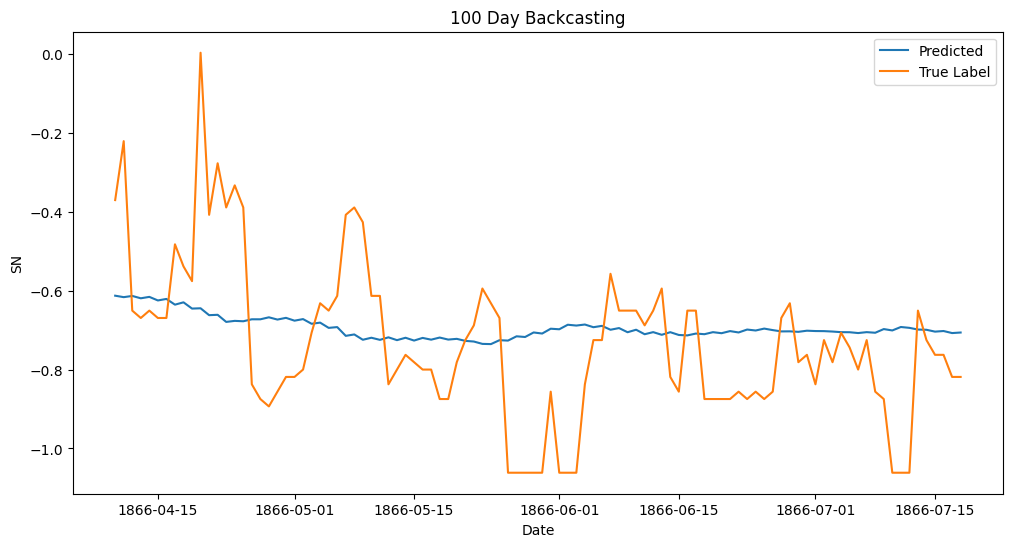

In [98]:
#100 Days Backcast

# Load dataset
viz_hundred = viz_hundred.set_index('Date')

# Plot two columns in one chart
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(viz_hundred.index, viz_hundred['sn_pred'], label='Predicted')
ax.plot(viz_hundred.index, viz_hundred['sn_true'], label='True Label')

# Add labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('SN')
ax.set_title('100 Day Backcasting')
ax.legend()

# Show plot
plt.show()


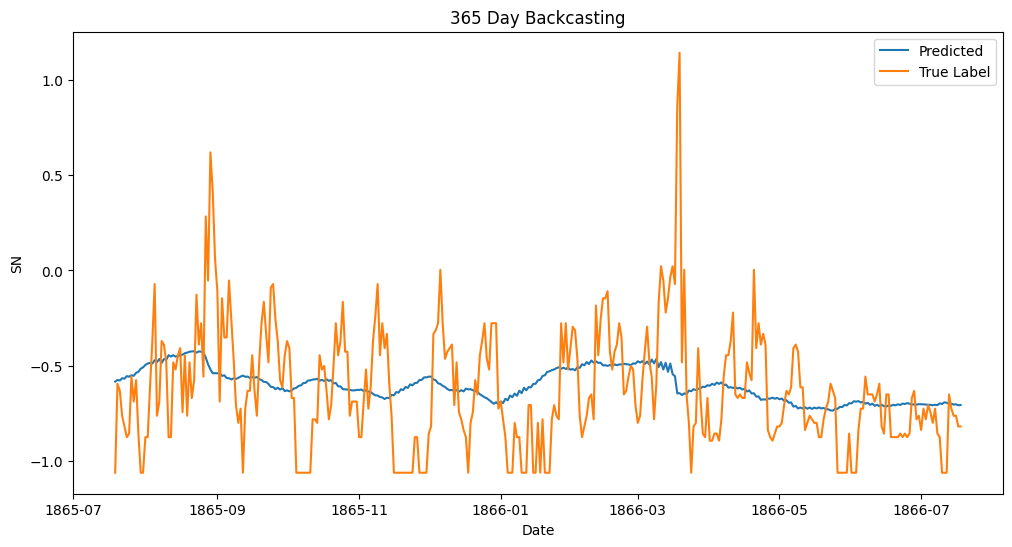

In [99]:
#365 Days Backcasting

# Load dataset
viz_year = viz_year.set_index('Date')

# Plot two columns in one chart
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(viz_year.index, viz_year['sn_pred'], label='Predicted')
ax.plot(viz_year.index, viz_year['sn_true'], label='True Label')

# Add labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('SN')
ax.set_title('365 Day Backcasting')
ax.legend()

# Show plot
plt.show()




In [100]:
import pickle

# Save the trained model
model.save('/content/drive/MyDrive/Model/CNN-BiLSTM-Attention_Model_Backcast_multiple features.h5')

# Save the history object
with open('/content/drive/MyDrive/Model/CNN-BiLSTM-Attention_history_Backcast_27.multiple features', 'wb') as f:
    pickle.dump(history.history, f)

In [ ]:
#Use Model To Forecasting
#Load Library, Model, and Addition First
#1. Merge array data for base predict
x_data = np.vstack((X_train, X_val, X_test))

In [ ]:
#2. test model prediction
import numpy as np

# Set the window size and n_steps
n_steps = 100 # 100 days

# Get the last window_size data points
start_index = len(x_data) - n_steps
n_step = x_data[start_index:]

# Make the predictions
y_pred = model.predict(n_step)

In [ ]:
#3. Invers to original data
inv_data = scaler.inverse_transform(y_pred)

In [ ]:
#4. Copy Dataframe
viz = df_sn.copy()

In [ ]:
df_sn.tail()

In [ ]:
import pandas as pd

# Define the start date (100 days before 1900-01-01)
start_date = pd.to_datetime('1850-01-01') - pd.Timedelta(days=99)

# Create a date range from the start date up to 1900-01-01
date_range = pd.date_range(start=start_date, end='1850-01-01', freq='D')

# Print the date range
print(date_range)


In [ ]:
#6. Merge Forecasting Date and Data
past = pd.DataFrame()
past["Date"] = date_range
past['Sn'] = inv_data
past

In [ ]:
#7. Copy historical data for Visualization
history_predict = n_steps #Set by window_size, 100 days

hist_data = df_sn.copy()
hist_data

start_index = len(hist_data) - history_predict
hist_data = hist_data[start_index:]

In [ ]:
#8. Set Index
hist_data = hist_data.set_index('Date')
past_data = past.set_index('Date')


In [ ]:
#9. Visualization

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 5))
hist_data.plot(ax=ax, label='Training Data', title='Observed Data')
past_data.plot(ax=ax, label='Predicted')
#ax.axvline('1900-01-01', color='black', ls='--')
ax.legend(['Training Set', 'Predicted'])
plt.show()